In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys, os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import Ridge, SGDRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, cross_validate
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.svm import SVC
from sklearn.preprocessing import scale, StandardScaler, MinMaxScaler, QuantileTransformer
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, Binarizer
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import RFE, RFECV
from sklearn.decomposition import PCA, SparsePCA
from sklearn.pipeline import Pipeline
from joblib import Parallel, delayed
import itertools


# Capital loss prevention : recovered capital prediction

To begin the analysis of the regression of the amount of capital recovered from charged off loans first
we define some functions which will help reduce the amount of recycled code. These functions are written in order
to enable a custom parallelized cross validation process. These functions were originally developed for the loan
outcome classification modeling because of the specific order of operations and encoding required. While these functions aren't
as necessary here, reusing them allows for a more efficient modeling process.

In [2]:
# Return the explained variance score given some test data. 
def my_score(clf, X_test, y_test):
    '''
        Predict using trained scikit-learn estimator and compute the explained variance score  
        
        Parameters:
        
        X_test : ndarray or DataFrame (n_samples, n_features)
                 Feature data to test. n_features represents the number of features
                 present in the data used to train the estimator clf
                 
        y_test : ndarray (n_samples, )
                 Target data to test. 
                
        
        clf : scikit-learn estimator which has been fit to data with same number of columns as X_test
        
        Returns:
        
        Explained variance score of predicted data
        
    '''
    y_predict = clf.predict(X_test)
    return explained_variance_score(y_test, y_predict)

# Return multiple scores and plot predicted vs. true. 
def classifier_analysis(clf, X_test, y_test):
    
    '''
        Predict using trained scikit-learn estimator and compute and plot various metrics:
        Prints 
        
        Parameters:
        
        X_test : ndarray or DataFrame (n_samples, n_features)
                 Feature data to test. n_features represents the number of features
                 present in the data used to train the estimator clf
                 
        y_test : ndarray (n_samples, )
                 Target data to test. 
                
        
        clf : scikit-learn estimator which has been fit to data with same number of columns as X_test
        
        target_transformer_ : scikit-learn scaler such as QuantileTransformer(), MinMaxScaler(), etc.
        
    
        
        Returns:
        
        y_test : ndarray (n_samples, )
            
            Same as input for convenience
        
        y_predict : ndarray (n_samples, ) 
            
            Predictions 
        
    '''
    
    y_predict = clf.predict(X_test)
    
    # Print the mean squared error and explained variance
    mse_ = mean_squared_error(y_test, y_predict)
    evs_ = explained_variance_score(y_test, y_predict)
    print('Mean squared error {}'.format(mse_))
    print('Explained variance score {}'.format(evs_))

    # Plot true vs. predicted as scatter plot. 
    ym = np.max(y_test)
    fig = plt.figure()
    plt.scatter(y_test, y_predict, s=1)
    plt.plot([0, ym],[0, ym],color='r')
    plt.ylabel('Predicted Value')
    plt.xlabel('True Value')
    plt.grid()
    plt.xlim([0, 1.1*ym])
    plt.ylim([0, 1.1*ym])
    _ = plt.show()
    
    return y_test, y_predict

In [3]:
def scale_features(col_transformer_, X_train, X_test, pca=None):
    '''
    Fits ColumnTransformer() to feature training data and then 
    transforms train and test data. 

    Parameters:

    col_transformer : ColumnTransformer instance
    
        Transformer that can be used to rescale and encode data.

    X_train : ndarray or DataFrame (n_samples, n_features)
    
        Feature data to scale. 

    X_test : ndarray (test_samples, n_features)
    
        Target data to scale. 

    Returns:

    X_train_scaled : ndarray or DataFrame (n_samples, n_features)
    
        Scaled training data.

    X_test_scaled : ndarray (test_samples, n_features)
    
        Scaled test data.            
            
            
    '''
    _ = col_transformer_.fit(X_train)
    X_train_scaled = col_transformer_.transform(X_train)
    X_test_scaled = col_transformer_.transform(X_test)
    
    if pca is not None:
        pcatransformer = PCA(n_components=pca)
        _ = pcatransformer.fit(X_train_scaled.toarray())
        X_train_scaled = pcatransformer.transform(X_train_scaled.toarray())
        X_test_scaled = pcatransformer.transform(X_test_scaled.toarray())
    
    return X_train_scaled, X_test_scaled

def scale_target(target_transformer_, y_train, y_test):
    '''
    Fits transformer to target training data and then 
    transforms target train and target test data. 

    Parameters:

    target_transformer_ : scikit-learn preprocessing scaler
    
        Transformer that can be used to rescale and encode target data.

    y_train : ndarray or DataFrame (n_samples, )
    
        Target training data to scale. 

    y_test : ndarray (test_samples, )
    
        Target testing data to scale. 

    Returns:

    y_train_scaled : ndarray or DataFrame (n_samples, n_features)
    
        Scaled training data.

    y_test_scaled : ndarray (test_samples, n_features)
    
        Scaled test data.   
            
    '''
    if target_transformer_ is not None:
        _ = target_transformer_.fit(y_train.reshape(-1,1))
        y_train_scaled = target_transformer_.transform(y_train.reshape(-1,1))
        y_test_scaled = target_transformer_.transform(y_test.reshape(-1,1))    
        return y_train_scaled.ravel(), y_test_scaled.ravel()
    else:
        return y_train.ravel(), y_test.ravel()
    
# This isn't cross validation its just model training. Cross-validation averages over the trained models of a parameter value
def my_cross_validate(estimator, col_transformer_, target_transformer_, X_traintest, y_traintest, param_grid, pca=None):
    '''
    Custom cross validation procedure which computes KFold cross validation (5 folds) for sets of parameters
    over training and testing data. Runs in parallel using joblib. 

    Parameters:

    estimator : DataFrame (n_samples, n_features)
         
        Dataframe which contains datetime features and value "Missing" which indicates missing values.

    col_transformer : ColumnTransformer instance
    
        Transformer that can be used to rescale and encode feature data.

    target_transformer_ : scikit-learn preprocessing scaler
    
        Transformer that can be used to rescale and encode target data.
                  
    X_traintest : ndarray, DataFrame (n_samples, n_features)
         
        Array containing the training and testing data of the feature variable. 

    y_traintest : ndarray (n_samples, )
         
        Array containing the training and testing data of the target variable. 
        
    param_grid : dict
         
        scikit-learn style parameter grid; dict whose keys are strings and whose values are sensible
        values for the corresponding keyword arguments of the scikit-learn estimator denoted by estimator.
        Values can be singular values or lists of values.

    Returns:

    estimator : scikit-learn Regressor
    
        Best model after cross validation
            
            
            
    '''
    mean_scores = []
    # cv_params needs to make sense for the estimator given
    param_grid_list = param_grid_iterable(param_grid)
    for params_ in param_grid_list:
        with Parallel(n_jobs=-1) as parallel:
            fitted_models_and_test_splits = parallel(delayed(fit_model_)
                                                     (estimator(**params_), col_transformer_, target_transformer_,
                                                          X_traintest, y_traintest, train, test, pca=pca)
                                  for (train, test) in KFold(n_splits=5).split(X_traintest, y_traintest))
            
            # Get averages (explained variance) score for this model
            scores = parallel(delayed(my_score)(model_, xt, yt) for (model_, xt, yt) in fitted_models_and_test_splits) 
            mean_scores += [np.mean(list(scores))]
            
    
    best_params_ = param_grid_list[np.argmax(np.array(mean_scores))]
    return estimator(**best_params_), (param_grid_list, mean_scores)


def fit_model_(estimator, col_transformer_, target_transformer_, X_traintest, y_traintest, train, test, pca=None):
    '''
    

    Parameters:

    estimator : DataFrame (n_samples, n_features)
         
        Dataframe which contains datetime features and value "Missing" which indicates missing values.

    col_transformer : ColumnTransformer instance
    
        Transformer that can be used to rescale and encode feature data.

    target_transformer_ : scikit-learn preprocessing scaler
    
        Transformer that can be used to rescale and encode target data.
                  
    X_traintest : ndarray, DataFrame (n_samples, n_features)
         
        Array containing the training and testing data of the feature variable. 

    y_traintest : ndarray (n_samples, )
         
        Array containing the training and testing data of the target variable. 
        
    param_grid : dict
         
        scikit-learn style parameter grid; dict whose keys are strings and whose values are sensible
        values for the corresponding keyword arguments of the scikit-learn estimator denoted by estimator.
        Values can be singular values or lists of values.

    Returns:

    (estimator, X_test, y_test) : tuple
    
        Tuple consisting of the fitted estimator and testing data sets (for convenience).
            
    '''
    X_train, X_test = X_traintest.iloc[train,:], X_traintest.iloc[test,:]
    y_train, y_test = y_traintest.iloc[train].values.ravel(), y_traintest.iloc[test].values.ravel()
    
    X_train, X_test  = scale_features(col_transformer_, X_train, X_test, pca=pca)
    y_train, y_test = scale_target(target_transformer_, y_train, y_test)

    _ = estimator.fit(X_train, y_train)    
    return (estimator, X_test, y_test)

def param_grid_iterable(params):
    '''
    Converts scikit-learn style parameter grid to tuples of 
    
    Parameters:

    params : dict
         
        Dictionary of the same style as scikit-learn parameter grid. 

    Returns:
    
    cvsorted : list
        
        List of combinations (dict) of parameter values. 

    '''
    keys = sorted(params)
    combinations = list(itertools.product(*(params[key] if type(params[key]) in [list, dict, np.ndarray] else [params[key]]
                                            for key in keys)))
    cvsorted = [dict(zip(len(c)*keys, c)) for c in combinations]
    return cvsorted

In [4]:
def cross_validated_model(estimator, col_transformer_, target_transformer_, X_traintest, 
                                  y_traintest, X_holdout, y_holdout, param_grid, pca=None):
    '''
    Parameters:

    estimator : DataFrame (n_samples, n_features)
         
        Dataframe which contains datetime features and value "Missing" which indicates missing values.

    col_transformer : ColumnTransformer instance
    
        Transformer that can be used to rescale and encode feature data.

    target_transformer_ : scikit-learn preprocessing scaler
    
        Transformer that can be used to rescale and encode target data.
                  
    X_traintest : ndarray, DataFrame (n_samples, n_features)
         
        Array containing the training and testing data of the feature variable. 

    y_traintest : ndarray (n_samples, )
         
        Array containing the training and testing data of the target variable. 
        
    X_holdout : ndarray, DataFrame (n_holdout_samples, n_features)
         
        Array containing the training and testing data of the feature variable. 

    y_holdout : ndarray (n_holdout_samples, )
         
        Array containing the training and testing data of the target variable.
        
    param_grid : dict
         
        scikit-learn style parameter grid; dict whose keys are strings and whose values are sensible
        values for the corresponding keyword arguments of the scikit-learn estimator denoted by estimator.
        Values can be singular values or lists of values.

    Returns:

    (estimator, X_holdout_final, y_holdout_final) : tuple
    
        Tuple consisting of the fitted estimator and scaled, hold out data sets. 
            
    '''
    # Initialize the cross-validation method
    kf = KFold(n_splits=5)
    
    # Using joblib, run my cross validation function; it scales feature and target data in the correct way 
    # in combination with cross validation.
    best_model_, (param_grid_list, mean_scores) = my_cross_validate(estimator, col_transformer_, target_transformer_, X_traintest, y_traintest, param_grid)
    
    # Using all of the traintest data; transform both the traintest and holdout data sets.
    X_traintest_final, X_holdout_final = scale_features(col_transformer_, X_traintest, X_holdout)
    y_traintest_final, y_holdout_final = scale_target(target_transformer_, y_traintest.values.ravel(), y_holdout.values.ravel())

    _ = best_model_.fit(X_traintest_final, y_traintest_final)
        
#     # Print final scores and plot the y_true vs y_pred
#     classifier_analysis(best_model_, X_holdout_final, y_holdout_final)
    
    return (best_model_, X_holdout_final, y_holdout_final, param_grid_list, mean_scores)

In [5]:
# Convert date-like + 'Missing' valued features to one-hot encoded columns; uses KBins on the years of the date-like, which 
# bins then one-hot encodes, while also one-hot encoding 'Missing' separately. 
def encode_dates_and_missing(df):
    
    '''
    A DataFrame which takes mixed "Missing" and datetime values, separates out the "Missing"
    and then performs two operations. First, the 'Missing' column is one-hot encoded, second,
    the datetime variables are binned and encoded using KBinsDiscretizer, using a uniform bin
    width strategy. 

    Parameters:

    df : DataFrame (n_samples, n_features)
         
        Dataframe which contains datetime features and value "Missing" which indicates missing values.

    Returns:

    encoded_df : DataFrame (n_samples, (undetermined size))
    
        Encoded dataframe, filled with one-hot encoded columns of the input DataFrame. 
            
            
            
    '''
    
    for i, seriesname in enumerate(df.columns):
        series = df[seriesname]
        series_missing = pd.get_dummies(series[series=='Missing'])
        series_notmissing = series[series!='Missing']
        notmiss_index = series_notmissing.index
        
        kbd = KBinsDiscretizer(n_bins=10, strategy='uniform')
        series_dt = pd.to_datetime(series_notmissing).dt.year
        encoded_series = kbd.fit_transform(series_dt.values.reshape(-1,1))
        encoded_series = pd.DataFrame(kbd.fit_transform(series_dt.values.reshape(-1,1)).toarray(), index=notmiss_index).astype(int)
        encoded_series = encoded_series.join(series_missing, how='outer').fillna(value=0)
        least_populated_feature = np.array([encoded_series[col].sum() for col in encoded_series.columns]).argmin()
        encoded_series = encoded_series.drop(columns=encoded_series.columns[least_populated_feature])
        encoded_series.columns = [seriesname+'_'+str(col) for col in encoded_series.columns]

        if i == 0: 
            encoded_df = encoded_series
        else:
            encoded_df = pd.concat((encoded_df,encoded_series),axis=1)
            
    return encoded_df
    

In [6]:
def my_feature_transformer(X, num_features, cat_features, date_features, num_transformer=StandardScaler()):
    ''' Transform features using a column transformer. 
    
    A DataFrame which takes mixed "Missing" and datetime values, separates out the "Missing"
    and then performs two operations. First, the 'Missing' column is one-hot encoded, second,
    the datetime variables are binned and encoded using KBinsDiscretizer, using a uniform bin
    width strategy. 

    Parameters
    ----------

    X : DataFrame (n_samples, n_features)
         
        Dataframe which contains training data. 

    num_features : list, Pandas index
    
        List of Pandas Index of the name of columns that contain numerical features.
         

    cat_features : list, Pandas index
    
        List of Pandas Index of the name of columns that contain categorical features.
         
    date_features : list, Pandas index
    
        List of Pandas Index of the name of columns that contain categorical features.
         
        Dataframe which contains datetime features and value "Missing" which indicates missing values.

    num_transformer : scikit-learn Transformer
         
        scikit-learn scaler such as QuantileTransformer(), MinMaxScaler(), etc.

    Returns
    -------

    col_transformer : ColumnTransformer instance
    
         Transformer that can be used to rescale and encode data. 
            
    '''
    
#     uniq_categories = [list(np.sort(X[col].unique()))+['Missing','Unknown'] for col in cat_features]


    
    transformer_list = []
    if num_transformer is not None:
        transformer_list += [('num', num_transformer, num_features)] 

    if cat_features is not None:        
        uniq_categories = [list(np.sort(X[col].unique())) for col in cat_features]
        # Previously dropped first category, this is more strategic.
        least_populated_categories = [X[col].value_counts().idxmin() for col in cat_features]
        cat_transformer = OneHotEncoder(categories=uniq_categories, drop=least_populated_categories)
        transformer_list += [('cat', cat_transformer, cat_features)] 
        
    if date_features is not None:             
        transformer_list += [('my_kbd', 'passthrough', date_features)] 

    col_transformer = ColumnTransformer(transformers=transformer_list)

    return col_transformer


The deliverable model that is about to be produced is one that predicts the amount of recoverable money from a "charged off" loan. This is performed via two different regression methods, Ridge regression and stochastic gradient descent. There is no time dependent component of the hypothesis in this case; that is, no special time order is required. To produce these two models all data needs to be in a numerical form, which requires the encoding of categorical variables. The procedure for
how we first produce these models is as follows:

    1. Take the subset of the data which corresponds to charged-off loans (already done).
    2. Perform preprocessing operations (Categorical variable encoding and numerical variable rescaling).
    3. Cross-validate a Ridge regression model
    4. Cross-validate a StochasticGradientDescent model
    5. Analyze the effectiveness of each model with various metrics.
    6. Decide on a final deliverable model.

The modeling in this notebook is regression of a continuous variable. There are many categorical type variables which
need to be encoded in order to be used for regression. There are a number of categorical variables with a large (100+) number of categories. In order to better handle this fact there are a number of features which we prune from our analysis.

The modeling in this notebook is regression of a continuous variable. There are many categorical type variables which
need to be encoded (transformed to numerical values) in order to be used for regression. A portion of these variables have a large (100+) number of categories.

In [7]:
loan_data = pd.read_csv('../data/regression_loan_data.csv', index_col=False)

The first step: drop all features which offer redundant information: this is determined
by correlation coefficient for the numerical features and by simple recognition for the
categorical variables. For instace, the grade of a loan (letter, A-E) is less precise than then subgrade (letter + number).

In [8]:
loan_data = loan_data.drop(columns=['fico_range_high', 'last_fico_range_high',
                                                    'zip_code', 'grade', 'total_pymnt_inv',
                                                    'funded_amnt', 'funded_amnt_inv'])

For expediency, take a small sample for preliminary calculations.

In [9]:
loan_data_sample = loan_data.sample(n=20000, random_state=0)

In [10]:
#Still contains missing values; first, drop features with missing values (dropping samples leaves us with no data).
# loan_data_sample = loan_data_sample.dropna(axis=1)

There are twenty loans whose principal amount has been paid off; remove these from the dataset.

In [11]:
loan_data_sample.select_dtypes(include='number').shape

(20000, 56)

In [12]:
loan_data_sample.shape

(20000, 75)

In [13]:
loan_data_sample.select_dtypes(include='object').nunique().sort_values(ascending=False).head(10)

earliest_cr_line             573
sec_app_earliest_cr_line     185
last_pymnt_d                  78
issue_d                       76
last_credit_pull_d            68
settlement_date               62
debt_settlement_flag_date     53
addr_state                    50
sub_grade                     35
purpose                       13
dtype: int64

The prediction is occuring in the present moment. All of the data corresponding to charged-off loans can be used, and it does not have to be treated as a time series, as we are not trying to predict the future.

As can be seen, the variables with the second to eight largest number of categories are related to dates; These features, from the cleaning process, are a mixture of dates (month-year) and the category 'Missing'. These variables will be encoded using binning, specifically KBinsDiscretizer using the One-hot encoding strategy with a small number of bins per feature vector. The manner with which we bin is to represent the dates by their year, and then use a uniform bin-width strategy with three bins.

Simultaneously, the "Missing" values are one-hot-encoded separately, such that the result is three bins for the date's years and an additional bin for the 'Missing' Category.
In summary the process is as follows: separate date-like and 'Missing' values. One-hot encode 'Missing' and dates binned by year separately.

The largest number of categories belongs to the zip code variable; which is reported as the first three digits (followed by 'xx'). We can reduce the number of categories by aggregating by the first *two* digits; but if we do this it is almost nearly
the same as identifying by the state; In fact, roudning to two digits is actually less specific than identifying by the state. We already have the state in 'addr_state' feature data so there is no motivation to keep the zip codes; if we're going to reduce it to two digits.

Additionally, the grade of each loan is less precise that the subgrade of each loan such that we dispose of this as well. 

I left these next calculations here for posterity, but it turns out that handling the datetime-like variables in this binning manner introduced a lot of noise into the models.

In [14]:
date_features = ['last_pymnt_d', 'debt_settlement_flag_date',
                 'last_credit_pull_d', 'issue_d', 'settlement_date',
                 'sec_app_earliest_cr_line', 'earliest_cr_line']

In [15]:
date_df = loan_data_sample[date_features]
date_data = encode_dates_and_missing(date_df)
num_and_cat_data = loan_data_sample.drop(columns=date_features)

In [16]:
# Assign target/training variables
y = num_and_cat_data.recoveries
X = num_and_cat_data.drop(columns=['recoveries', 'collection_recovery_fee'])#.loc[y.index,:]

In [18]:
num_features = X.select_dtypes(include='number').columns
cat_features = X.select_dtypes(include='object').columns

Default cross validation is KFold with 5 folds; by default shuffling is off so we technically do not need to pass a random state.

In [19]:
X_traintest, X_holdout, y_traintest, y_holdout = train_test_split(X, y, test_size=0.2, random_state=321789)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_traintest, y_traintest, test_size=0.2, random_state=548793)

In [21]:
col_transformer_ = my_feature_transformer(X, num_features, cat_features, None, num_transformer=StandardScaler())
_ = col_transformer_.fit(X_train)
X_train_transformed = col_transformer_.transform(X_train)
X_test_transformed = col_transformer_.transform(X_test)

In [22]:
print('Shape of the training set {} and testing set {} before transformation'.format(X_train.shape,
                                                                                    X_test.shape))
print('Shape of the training set {} and testing set {} after transformation'.format(X_train_transformed.shape,
                                                                                    X_test_transformed.shape))

Shape of the training set (12800, 66) and testing set (3200, 66) before transformation
Shape of the training set (12800, 176) and testing set (3200, 176) after transformation


#### Preliminary tests

For each model we make a preliminary test on the training data; this is similar to the no-information rate type
analysis in classification problems. That is, we train and test with the same data set. If the model is inaccurate
in this case then there is something seriously wrong with the data or the model. 

For these tests we shall leave the target variable untransformed; the features need to be transformed to
format the categorical variables accordingly. While there are an incredible number of options for fine tuning 
the main investigation is into the efficacy of the numerical feature transformers. 

Preliminary tests to ensure that nothing outrageously wrong with preprocessing.

Mean squared error 42.51778565776719
Explained variance score 0.999988226779694


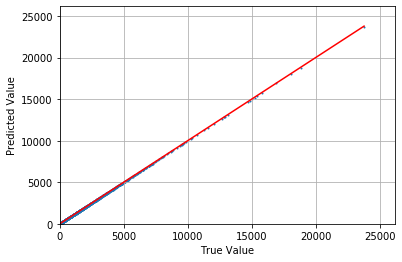

In [23]:
sgd = SGDRegressor(random_state=42, max_iter=10000)
_ = sgd.fit(X_train_transformed, y_train.values.ravel())
ysgd, ysgd_predict = classifier_analysis(sgd, X_test_transformed, y_test.values.ravel())

Mean squared error 14.632365296732207
Explained variance score 0.9999959491424831


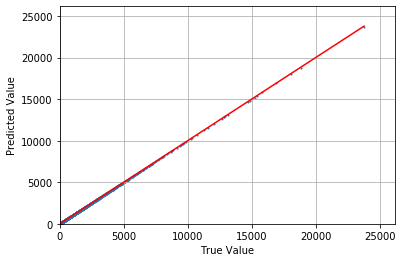

In [24]:
rdge = Ridge()
_ = rdge.fit(X_train_transformed, y_train.values.ravel())
yrdge, yrdge_predict = classifier_analysis(rdge, X_test_transformed, y_test.values.ravel())

These results seem far too good to be realistic. I investigate this claim by a crude yet effective
method of performing the same training and testing, increasing the number of included features one at a time. 

In [25]:
evscore0 = []
for n_slice in range(1, X_train_transformed.shape[1]):
    rdge = Ridge(tol=1e-01)
    _ = rdge.fit(X_train_transformed[:,:n_slice], y_train.values.ravel())
    evscore0 += [my_score(rdge, X_test_transformed[:,:n_slice], y_test.values.ravel())]

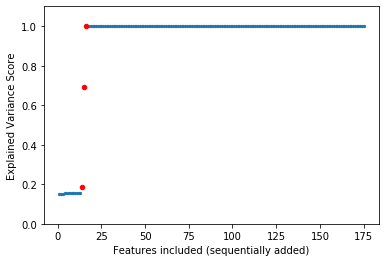

In [26]:
n_pca_list = range(1, X_train_transformed.shape[1])
plt.scatter(n_pca_list, evscore0, s=5)
plt.scatter(n_pca_list[13:16], evscore0[13:16], s=20, color='r')
plt.ylim([0, 1.1])
plt.xlabel('Features included (sequentially added)')
plt.ylabel('Explained Variance Score')
plt.savefig('explained_variance_vs_features_included.jpg', bbox_inches='tight')
_ = plt.show()

There is an incredible jump in explained variance that happens as three specific features (the first jump is small in relative terms but significant) as if to indicate a collinearity between these two columns and the target variable, first, the names of the columns

In [27]:
print(X_train.iloc[:, 13:16].columns.tolist())

['total_pymnt', 'total_rec_prncp', 'total_rec_int']


second, as a test, compare these columns with the target variable using correlations

In [28]:
print(X_train.iloc[:, 13:16].corrwith(y_train))

total_pymnt        0.376520
total_rec_prncp    0.026574
total_rec_int      0.190212
dtype: float64


In [29]:
print(X_test.iloc[:, 13:16].corrwith(y_test))

total_pymnt        0.390564
total_rec_prncp    0.053083
total_rec_int      0.206087
dtype: float64


I do not believe that there is any contamination between these features but at the same time they seem to perform
too well as predictive variables. Therefore my recommendation would be to uncover a more detailed explanation of
the relation between these two features and the target variable. Until then, a cautious application of this model
is recommended. Unfortunately the performance in the absence of these three features is **pretty terrible** at least
with these preliminary tests on a sample of the total data.

According to the metadata, the definitions of the three features are:

    1. total_pymnt : Payments received to date for total amount funded

    2. total_rec_prncp : Principal received to date

    3. total_rec_int : Interest received to date

And the target variable:
    
    recoveries : post charge off gross recovery

Note that this isn't a time dependent problem so a possible is that total payments perhaps include post charge off gross recovery. and there does not seem to be any glaring relations between
these three variables, while unlikely, it may be that these features are simply very good descriptors. With no
way to know or follow up, I continue towards the full regression problem. 

In [30]:
X_train_transformed_slice_test = np.concatenate((X_train_transformed[:, :13], X_train_transformed[:, 16:]), axis=1) 
X_test_transformed_slice_test = np.concatenate((X_test_transformed[:, :13], X_test_transformed[:, 16:]), axis=1) 

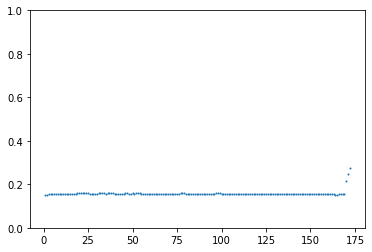

In [31]:
evscore_slice = []
n_slice_list = range(1, X_train_transformed_slice_test.shape[1])

for n_slice in n_slice_list:
    rdge = Ridge(tol=1e-01)
    _ = rdge.fit(X_train_transformed_slice_test[:,:n_slice], y_train.values.ravel())
    evscore_slice += [my_score(rdge, X_test_transformed_slice_test[:,:n_slice], y_test.values.ravel())]
     
plt.scatter(n_slice_list, evscore_slice, s=1)
plt.ylim([0, 1])
_ = plt.show()

Mean squared error 2660799.2435166766
Explained variance score 0.26456401971167


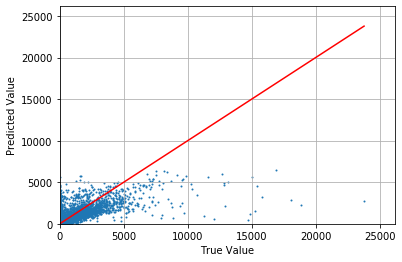

In [32]:
sgd = SGDRegressor(random_state=42, max_iter=10000)
_ = sgd.fit(X_train_transformed_slice_test, y_train.values.ravel())
ysgd, ysgd_predict = classifier_analysis(sgd, X_test_transformed_slice_test, y_test.values.ravel())

Mean squared error 2621596.1672063
Explained variance score 0.27428367941919274


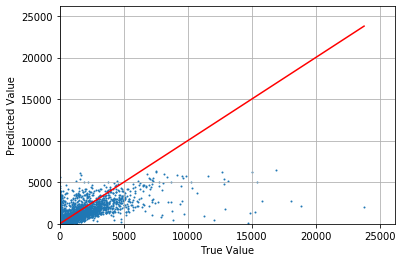

In [33]:
rdge = Ridge()
_ = rdge.fit(X_train_transformed_slice_test, y_train.values.ravel())
yrdge, yrdge_predict = classifier_analysis(rdge, X_test_transformed_slice_test, y_test.values.ravel())

Try the same thing but with only positive recovery values.  

In [34]:
# Assign target/training variables
y = num_and_cat_data.recoveries
y = y[y > 0]
X = num_and_cat_data.drop(columns=['recoveries', 'collection_recovery_fee',
                                  'total_pymnt', 'total_rec_prncp', 'total_rec_int']).loc[y.index,:]
num_features = X.select_dtypes(include='number').columns
cat_features = X.select_dtypes(include='object').columns

In [35]:
tmp_tuple = train_test_split(X, y, test_size=0.2, random_state=321789)
X_traintest_slice, X_holdout_slice, y_traintest_slice, y_holdout_slice = tmp_tuple

In [36]:
tmp_tuple2 = train_test_split(X_traintest, y_traintest, test_size=0.2, random_state=548793)
X_train_slice, X_test_slice, y_train_slice, y_test_slice = tmp_tuple2

In [37]:
col_transformer_ = my_feature_transformer(X, num_features, cat_features, None, num_transformer=StandardScaler())

_ = col_transformer_.fit(X_train_slice)
X_train_slice_transformed = col_transformer_.transform(X_train_slice)
X_test_slice_transformed = col_transformer_.transform(X_test_slice)

In [38]:
print('Shape of the training set {} and testing set {} before transformation'
      .format(X_train_slice.shape, X_test_slice.shape))
print('Shape of the training set {} and testing set {} after transformation'
      .format(X_train_slice_transformed.shape, X_test_slice_transformed.shape))

Shape of the training set (12800, 66) and testing set (3200, 66) before transformation
Shape of the training set (12800, 173) and testing set (3200, 173) after transformation


Mean squared error 2660795.133730312
Explained variance score 0.2645646134218318


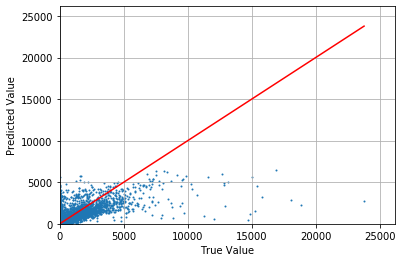

In [39]:
sgd = SGDRegressor(random_state=42, max_iter=10000)
_ = sgd.fit(X_train_slice_transformed, y_train_slice.values.ravel())
ysgd, ysgd_predict = classifier_analysis(sgd, X_test_slice_transformed,
                                         y_test_slice.values.ravel())

Mean squared error 2621294.1943806233
Explained variance score 0.27436859687164383


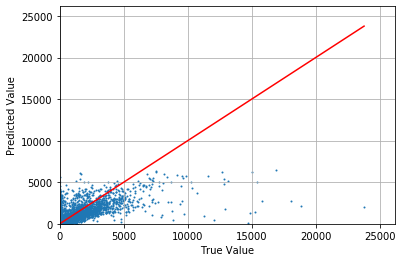

In [40]:
rdge = Ridge()
_ = rdge.fit(X_train_slice_transformed, y_train_slice.values.ravel())
yrdge, yrdge_predict = classifier_analysis(rdge, X_test_slice_transformed,
                                           y_test_slice.values.ravel())

As a reminder: this is only being performed on a sample of the true dataset as a preliminary test.
These results seem much more realistic, they are better than when including recovered values equal
to zero and they still agree with each other. Therefore, going forward, I choose to only use greater-than-zero
recovery amounts when working with the full dataset.

In light of these discoveries, I am going to create two models; one without and one with the suspicious features. Before
models are used there should be clarification or investigation into the specific definitions of these
features. The best practice seems to be to take a number of principal components of the feature data
pertaining to only non-zero post charge off gross recoveries.  

In [41]:
date_features = ['last_pymnt_d', 'debt_settlement_flag_date',
                 'last_credit_pull_d', 'issue_d', 'settlement_date',
                 'sec_app_earliest_cr_line', 'earliest_cr_line']

num_and_cat_data = loan_data.drop(columns=date_features)

# Assign target/training variables
y = num_and_cat_data.recoveries
y = y[y > 0]
X = num_and_cat_data.drop(columns=['recoveries', 'collection_recovery_fee',
                                  'total_pymnt', 'total_rec_prncp', 'total_rec_int']).loc[y.index,:]

num_features = X.select_dtypes(exclude=['object']).columns
cat_features = X.select_dtypes(include=['object']).columns

X_traintest, X_holdout, y_traintest, y_holdout = train_test_split(
    X, y, test_size=0.2)

### Model training and analysis

The column transformation process is included in the custom cross-validation modeling functions.
To be explicit, the cross-validation uses only "traintest" variables using a set of KFold cross-validation
folds. After the best model is chosen by the cross validation process (which uses explained variance as the
scoring parameter) then the model is trained on the entirity of the "traintest" set, and then tested using
the "holdout" set. At no point is the "holdout" data used in any training or data transformations. This ensures
that no data contamination or data snooping occurs.

There aren't an exceptional amount of hyperparameters to vary for stochastic gradient descent and ridge
regression. Instead, I elect to vary the numerical column transformer in addition to ridge regression
and stochastic gradient descent regressor's hyperparameters. Categorical variables (the datetime-like ones)
are removed from the discussion due to the amount of noise they introduce.

In [42]:
sgd_param_grid = {'random_state':0, 'alpha':[0.1, 1, 2],
                  'tol':[1e-1, 1e-3, 1e-5]}

ridge_param_grid = {'alpha':[0.1, 1, 2], 'tol':[1e-1, 1e-3, 1e-5]}

Initialize the column transformers which are identical up to numerical transformers. Currently the datetime like features
are not used because I think that the binning introduces too much noise and yields poor results. 

In [43]:
col_transformer_s = my_feature_transformer(
    X, num_features, cat_features, None, num_transformer=StandardScaler()
    )

col_transformer_m = my_feature_transformer(
    X, num_features, cat_features, None, num_transformer=MinMaxScaler()
    )

col_transformer_q = my_feature_transformer(
    X, num_features, cat_features, None, num_transformer=QuantileTransformer()
    )

Cross validate and find the best hyperparameter combination coefficient for each model + transformer combination. 

In [44]:
sgd_s = cross_validated_model(
    SGDRegressor, col_transformer_s, None, X_traintest, 
    y_traintest, X_holdout, y_holdout, sgd_param_grid, pca=None)

ridge_s = cross_validated_model(
    Ridge, col_transformer_s, None, X_traintest, 
    y_traintest, X_holdout, y_holdout, ridge_param_grid, pca=None)

In [45]:
sgd_m = cross_validated_model(
    SGDRegressor, col_transformer_m, None, X_traintest, 
    y_traintest, X_holdout, y_holdout, sgd_param_grid, pca=None)

ridge_m = cross_validated_model(
    Ridge, col_transformer_m, None, X_traintest, 
    y_traintest, X_holdout, y_holdout, ridge_param_grid, pca=None)

In [46]:
sgd_q = cross_validated_model(
    SGDRegressor, col_transformer_q, None, X_traintest, 
    y_traintest, X_holdout, y_holdout, sgd_param_grid, pca=None)

ridge_q = cross_validated_model(
    Ridge, col_transformer_q, None, X_traintest, 
    y_traintest, X_holdout, y_holdout, ridge_param_grid, pca=None)

Mean squared error 2390132.526375959
Explained variance score 0.4112757122070587


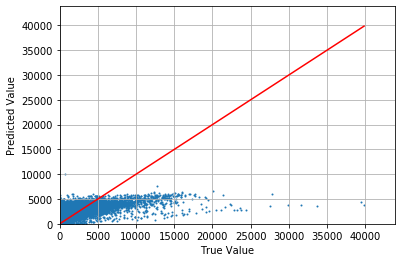

Mean squared error 2188359.7283567945
Explained variance score 0.46096879103177335


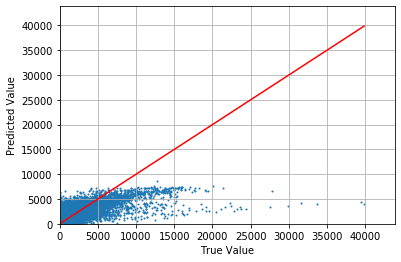

In [47]:
_ = classifier_analysis(*tuple(sgd_s[:3]))

y_s, y_s_predict = classifier_analysis(*tuple(ridge_s[:3]))

Mean squared error 2667575.735216274
Explained variance score 0.34302233345879807


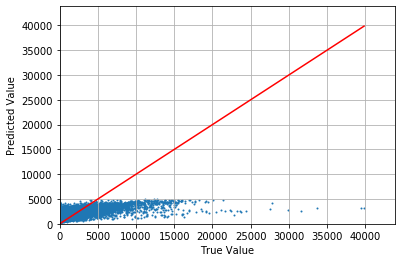

Mean squared error 2188044.852064052
Explained variance score 0.46104675405837237


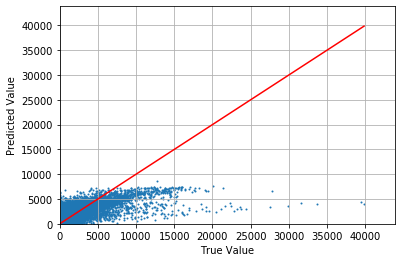

In [48]:
_ = classifier_analysis(*tuple(sgd_m[:3]))

y_m, y_m_predict = classifier_analysis(*tuple(ridge_m[:3]))

Mean squared error 2525382.843523381
Explained variance score 0.37834595088705225


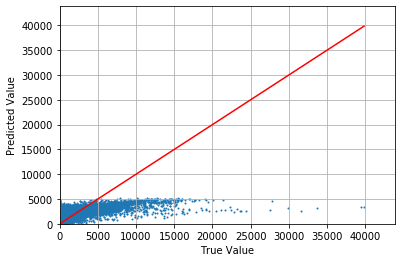

Mean squared error 2244153.816843416
Explained variance score 0.4472244548980744


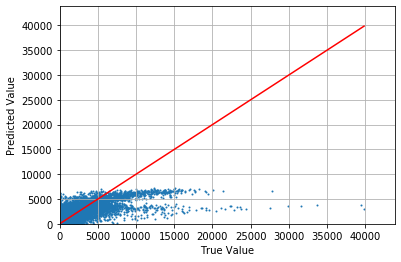

In [49]:
_ = classifier_analysis(*tuple(sgd_q[:3]))

y_q, y_q_predict = classifier_analysis(*tuple(ridge_q[:3]))

In [50]:
ridge_m[0]

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.1)

With the assumption that the three "suspicious" features are actually acceptable I shall
include them in another model.

In [51]:
date_features = ['last_pymnt_d', 'debt_settlement_flag_date',
                 'last_credit_pull_d', 'issue_d', 'settlement_date',
                 'sec_app_earliest_cr_line', 'earliest_cr_line']

num_and_cat_data = loan_data.drop(columns=date_features)

# Assign target/training variables
y = num_and_cat_data.recoveries
y = y[y > 0]
X = num_and_cat_data.drop(columns=['recoveries', 'collection_recovery_fee']).loc[y.index,:]
X_sliced = X.drop(columns=['total_pymnt', 'total_rec_prncp', 'total_rec_int']).loc[y.index,:]

num_features = X.select_dtypes(exclude=['object']).columns
cat_features = X.select_dtypes(include=['object']).columns
num_features_sliced = X_sliced.select_dtypes(exclude=['object']).columns
cat_features_sliced = X_sliced.select_dtypes(include=['object']).columns

X_traintest, X_holdout, y_traintest, y_holdout = train_test_split(X, y, test_size=0.2)
X_traintest_sliced, X_holdout_sliced, y_traintest_sliced, y_holdout_sliced = train_test_split(X_sliced, y, test_size=0.2)

While cross validation over various parameters is performed the main comparisons are made between the various choices
of numerical transformers; that is, the investigation here considers the four choices of combinations of QuantileTransformer()
and MinMaxScaler() for the feature and target data. This could and probably should be handled by nested cross validation. I look at some preliminary results to see if there is anything disastrously wrong with any of the transformer selections.  

The above plots represent results from scaling with MinMaxScaler on both feature and target data. 

    1. The prediction vs. true values for stochastic gradient descent
    2. The prediction vs. true values for ridge regression
    3. The ridge regression results from (2) mapped back to the original, unscaled space.

In every case the Ridge regression outperforms the stochastic gradient descent. 
Simple comparison of the true to predicted values of the application of MinMaxScaler() and QuantileTransformer() lead to very similar results.

| Scaling | Mean-squared error | Estimated variance |
| --- | --- | --- |
| QuantileTransformer | 2278262.7349281064 | 0.4270508478802073|
| MinMaxScaler | 2205599.158832141 | 0.44532419977748505|
| StandardScaler | 2381178.413802254 | 0.40166608575310014|

This makes MinMaxScaler the clear winner. I believe the reason the predictions diverge from the truth in the limit of large
recoveries is because there is not much data near the upper limit. It is hard to give a precise explanation because the
transformation is non-linear.

Mean squared error 2304264.631867433
Explained variance score 0.4514801677872017


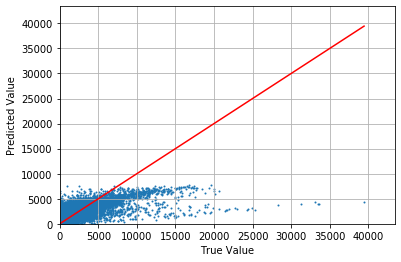

In [52]:
col_transformer_ = my_feature_transformer(X_sliced, num_features_sliced,
                                          cat_features_sliced, None, num_transformer=MinMaxScaler())

_ = col_transformer_.fit(X_traintest_sliced)
X_traintest_final_sliced = col_transformer_.transform(X_traintest_sliced)
X_holdout_final_sliced = col_transformer_.transform(X_holdout_sliced)


model = Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.1)
_ = model.fit(X_traintest_final_sliced, y_traintest_sliced.values.ravel())
_, y_predict_final = classifier_analysis(model, X_holdout_final_sliced, y_holdout_sliced)

Mean squared error 9.861350468204574
Explained variance score 0.9999975418989224


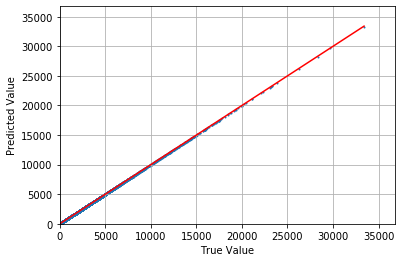

In [53]:
col_transformer_ = my_feature_transformer(X, num_features, cat_features, None, num_transformer=MinMaxScaler())
_ = col_transformer_.fit(X_traintest)
X_traintest_final = col_transformer_.transform(X_traintest)
X_holdout_final = col_transformer_.transform(X_holdout)

model = Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.1)
_ = model.fit(X_traintest_final, y_traintest.values.ravel())
_, y_predict_final = classifier_analysis(model, X_holdout_final, y_holdout)

It's quite clear that the inclusion of all of the features performs dramatically better, therefore the course of action would be to discover whether or not the inclusion of these features is valid. This is outside of my power, however, so the investigation ends here.
In summary, Ridge regression with small regularization (larger value = smaller regularization per scikit-learn's docs)
but a relatively strict tolerance seems to perform the best. 